# 作成したモデルのdeployとserving

このハンズオンでは、Vertex AIにモデルをデプロイし、推論APIとして利用できるようにしていきます。

先ほど作成した犬種/猫種判別モデルをデプロイすることで、その手順を確認していきましょう。

In [ ]:
%%bash
USER=username # 自分の名前
REGION=asia-northeast1
BUCKET=mixi-ml-handson-2023
MODEL=pet_model

gcloud ai models upload \
  --region=${REGION} \
  --display-name=oxford-pet-${USER} \
  --container-image-uri=asia-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-11:latest \
  --artifact-uri=gs://${BUCKET}/${USER}/${MODEL}

gcloud ai models list \
  --region=${REGION} \
  --filter=oxford-pet-${USER}
    
gcloud ai endpoints create \
  --region=${REGION} \
  --display-name=oxford-pet-${USER}

上記コードの実行には数分の時間がかかります。
実行が終わったら、出力されたMODEL_IDと、endpointを作成した際に出力された`ENDPOINT_ID` `・・・/asia-northeast1/endpoints/<ENDPOINT_ID>`を使って、endpointにmodelをdeployします。

In [ ]:
%%bash

USER=username # 自分の名前
REGION=asia-northeast1
MODEL_ID=___
ENDPOINT_ID=___

gcloud ai endpoints deploy-model ${ENDPOINT_ID} \
  --region=${REGION} \
  --model=${MODEL_ID} \
  --display-name=oxford-pet-${USER}


上記コードの実行には数分の時間がかかります。

versionの作成が完了したら、このendpointにリクエストを投げて結果が返ってくるか確認してみます。  
まず、02と同じようにデータセットを用意していきましょう。

In [1]:
import tensorflow as tf
import numpy as np

image_size = (200, 200)
batch_size = 16
DATASET_DIR = "../02_transfer_learning/dataset"

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=1111,
    image_size=image_size,
    batch_size=batch_size,
)

2023-05-01 08:53:56.574766: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 08:53:59.280282: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-01 08:53:59.280409: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

Found 7390 files belonging to 37 classes.
Using 1478 files for validation.


2023-05-01 08:54:03.915464: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-01 08:54:03.927643: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-01 08:54:03.929299: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-01 08:54:03.932204: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

データセットが用意できたら、endpointにリクエストを投げて結果を受け取るメソッドを作成します。

In [2]:
from google.cloud import aiplatform
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value

PROJECT_ID = 'hr-mixi'
ENDPOINT_ID = '___'
REGION = "asia-northeast1"

def predict_json(instances):    
    aiplatform.init(project=PROJECT_ID, location=REGION)
    endpoint = aiplatform.Endpoint(ENDPOINT_ID)
    instances = [json_format.ParseDict(s, Value()) for s in instances]
    response = endpoint.predict(instances=instances)
    return response.predictions

これで結果を受け取る部分はできたので、02で作成したpredict_datasetメソッドのresult部分を、作成したpredict_jsonメソッドに変えてみましょう。

In [3]:
def predict_dataset():
    for images, labels in val_data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            image = images[i].numpy()
            plt.imshow(image.astype("uint8"))
            norm_img = image / 255.0
            norm_img = np.expand_dims(norm_img, 0)
            norm_img = norm_img.tolist()
            result =  predict_json(norm_img)
            plt.title(
                "label:" + val_data.class_names[np.argmax(labels[i])] +
                "\npredict:" + val_data.class_names[np.argmax(result[0])]
            )
        plt.axis("off")

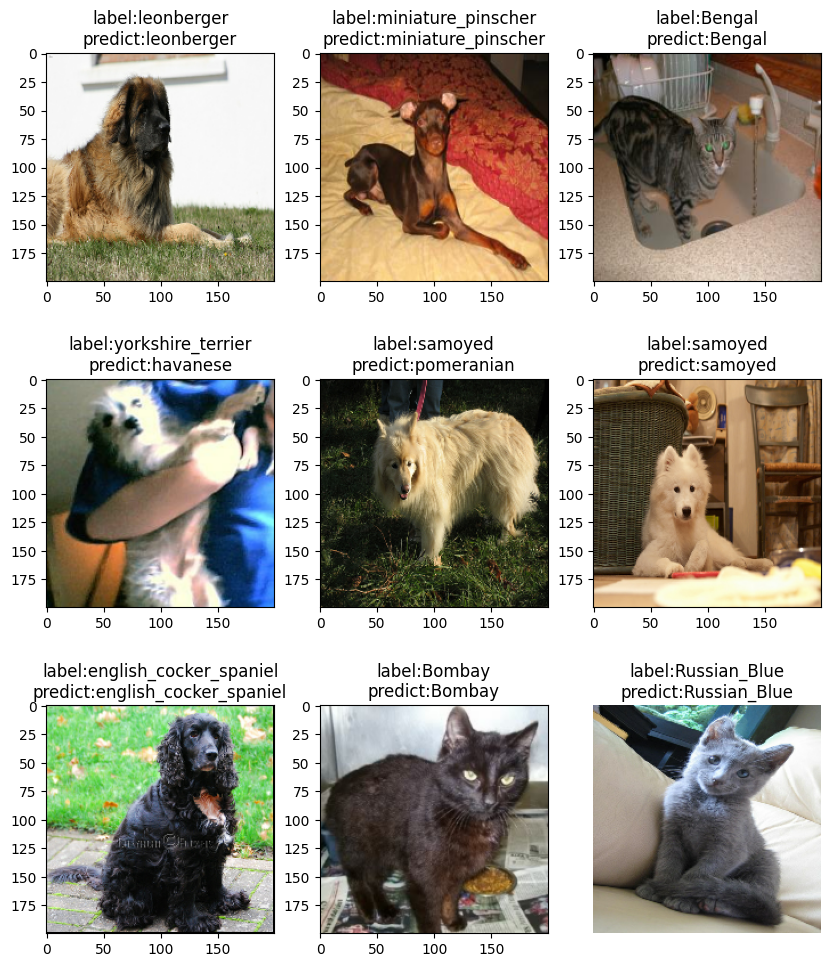

In [4]:
import matplotlib.pyplot as plt
labels = val_data.class_names

plt.figure(figsize=(10, 12))
predict_dataset()

これで、modelの部分を推論APIに置き換えることができました。

## Gradioを使って犬種/猫種判別を行うデモアプリを作成する

model部分のAPI化ができたので、機械学習を使った簡単なデモアプリを作ってみましょう。

まず、お手軽にML系のwebアプリケーションが作成できるgradioをinstallします。

In [5]:
!pip install -q --user gradio

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [6]:
import gradio as gr

上記ImportErrorがでた場合は、kernelをrestartして、bashコマンド以降のセルを改めて実行してみてください。

完了したら、デモアプリを作成してみましょう。  
コード実行ができたら、public URLを確認してみてください。

In [ ]:
labels = val_data.class_names

def predict(image):
    image = image / 255.0
    image = np.expand_dims(image, 0)
    image = image.tolist()
    pred = predict_json(image)[0]
    confidences = {labels[i]: pred[i] for i in range(len(labels))}    
    return confidences

demo = gr.Interface(predict, gr.Image(shape=(200, 200)), outputs=gr.outputs.Label(num_top_classes=5))

# <todo> ""部分に独自のuserとpasswordを入力してください。
# share=Trueになっていると、public URLとして公開されるため、必ず各自でpassを設定して入るようにしてください。
demo.launch(share=True, auth=("", ""))

犬種/猫種判定アプリが作れていましたでしょうか。  
データセットにない犬、猫などは、  
犬は、https://www.min-inuzukan.com/  
猫は、https://www.min-nekozukan.com/  
にあるので、これらを参考にしつつ正しく判別できるか試してみてください。 